# Switch SEDNA to both Xarray & Dask for the analyse

In [1]:
import dask_hpcconfig
from distributed import Client
dask_hpcconfig.print_clusters()
clusters = dask_hpcconfig.available_clusters()
clusters

Available clusters:
 • local: local
 • datarmor-local: local
 • datarmor: pbs
 • datarmor-seq: pbs


{'local': 'local',
 'datarmor-local': 'local',
 'datarmor': 'pbs',
 'datarmor-seq': 'pbs'}

In [2]:
memory_size = 25
n_worker_per_node = 115 // memory_size
n_threads_per_worker = 28 // n_worker_per_node
print(n_worker_per_node, n_threads_per_worker)

4 7


In [3]:
overrides = {
#    "cluster.threads_per_worker": n_threads_per_worker,
#    "cluster.n_workers": n_worker_per_node,
}

In [4]:
overrides

{}

In [5]:
cluster = dask_hpcconfig.cluster("datarmor", **overrides)
#cluster = dask_hpcconfig.cluster("datarmor-local", **overrides)  
client = Client(cluster)
client

/home1/datawork/ctalandi/conda-env/Jupyter-Dask/lib/python3.11/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)


Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.1.53:8787/status,
Dashboard: http://10.148.1.53:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.1.53:47153,Workers: 0
Dashboard: http://10.148.1.53:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [6]:
cluster.scale(jobs=3)

/home1/datawork/ctalandi/conda-env/Jupyter-Dask/lib/python3.11/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)


In [83]:
import xarray as xr 
import matplotlib.pylab as plt
import numpy as np
import hvplot.xarray
import cartopy.crs as crs

In [84]:
! date 

Tue Dec 12 16:32:37 GMT 2023


In [85]:
from mpl_toolkits.basemap import Basemap
import matplotlib as mpl

def Arc_plot(zlon,zlat,ztab,zcontours,zlim,zmap='Spectral_r',proj='cassi',fld=''): 

    #m = Basemap(projection='npstere',boundinglat=65,lon_0=-20, resolution='l')
    #proj='cassi'
    #proj='gin'
    #proj='cassisva'
    if proj == 'npstere' :
        m = Basemap(projection='npstere',boundinglat=75,lon_0=-140, resolution='l')
    elif proj == 'cassi' :
        m = Basemap(llcrnrlon=-170,llcrnrlat=68,urcrnrlon=-60,urcrnrlat=80, resolution='i',\
                    projection='cass',lon_0=-140,lat_0=60)  
    elif proj == 'gin' :
        m = Basemap(llcrnrlon=-20,llcrnrlat=60,urcrnrlon=60,urcrnrlat=80, resolution='i',\
                    projection='cass',lon_0=0,lat_0=65)    
    elif proj == 'cassis_BGZoom' :
        m = Basemap(llcrnrlon=-170,llcrnrlat=68,urcrnrlon=-110,urcrnrlat=80, resolution='i',\
                    projection='cass',lon_0=-140,lat_0=60)    
    elif proj == 'Heather' :
        m = Basemap(llcrnrlon=-110,llcrnrlat=80,urcrnrlon=-170,urcrnrlat=65, resolution='i',\
                    projection='cass',lon_0=0,lat_0=60)    

    
    zfontsize=12
    m.drawparallels(np.arange(-90.,91.,5.),labels=[True,False,True,False], size=zfontsize, linewidth=0.3, alpha=0.5)
    m.drawmeridians(np.arange(-180.,181.,20.),labels=[False,True,False,True], size=zfontsize, latmax=90.,linewidth=0.3,alpha=0.7)
    m.fillcontinents(color='grey')

    norm = mpl.colors.Normalize(vmin=limits[0], vmax=limits[1])

    X,Y = m(zlon,zlat)
    m.contourf(X,Y,ztab,zcontours,cmap=zmap,extend='both')
    cbar=plt.colorbar()
    cbar.set_label(fld, fontsize=12, rotation=270)
    cbar.ax.tick_params(labelsize=10)
    
    return m
    
    #zcontours=np.arange(0.,1000.,100)
    #C=m.contour(X,Y,ztab,levels=zcontours,colors='black',alpha=0.8)
    #plt.clabel(C,C.levels,inline=True,fmt='%.0f',fontsize=15)


In [86]:
def GeoBox(lfig,area='large'):
    props = dict(boxstyle='round', facecolor='y', alpha=1.0)

    if area == 'large' :     
        lfig.text(0.26, 0.17, 'ALASKA', color='k',fontsize=16, bbox=props, alpha=1.)
        lfig.text(0.64, 0.53, 'CANADIAN \n ARCHIPELAGO', color='k',fontsize=16, bbox=props, alpha=1.)
        props = dict(boxstyle='round', facecolor='w', alpha=1.0)
        lfig.text(0.41, 0.87, 'NORTH POLE', color='k',fontsize=16, bbox=props, alpha=1.)

        props = dict(facecolor='w', alpha=1.0)
        lfig.text(0.6, 0.17, 'ANR ImMEDIAT (LOPS)', color='grey',fontsize=16, bbox=props, alpha=1.)
        
    elif area == 'zoom' :
        lfig.text(0.28, 0.24, 'ALASKA', color='k',fontsize=16, bbox=props, alpha=1.)
        lfig.text(0.64, 0.53, 'CANADIAN \n ARCHIPELAGO', color='k',fontsize=16, bbox=props, alpha=1.)
        props = dict(boxstyle='round', facecolor='w', alpha=1.0)
        lfig.text(0.51, 0.8, 'NORTH POLE', color='k',fontsize=16, bbox=props, alpha=1.)
        
        props = dict(facecolor='w', alpha=1.0)
        lfig.text(0.6, 0.24, 'ANR ImMEDIAT (LOPS)', color='grey',fontsize=16, bbox=props, alpha=1.)

# SEDNA grid 

In [87]:
DDIR="/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/CONFIGS/CREG12.L75/GRID"
ds_sedna_bat=xr.open_dataset(DDIR+'/'+'bathymetry_CREG12_V3.3_CT20180612Larger_ct20190102.nc')

In [88]:
%%time 
CDIR='/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/CONFIGS/CREG12.L75/GRID/'
ds_coord=xr.open_dataset(CDIR+'coordinates_CREG12.L75.nc',chunks={'t':1 ,'z':15,'y':500, 'x':500})

CPU times: user 20 ms, sys: 0 ns, total: 20 ms
Wall time: 113 ms


In [89]:
ds_coord=ds_coord.set_coords('nav_lon')
ds_coord=ds_coord.set_coords('nav_lat')
#ds_coord=ds_coord.set_coords('nav_lev')
#ds_coord=ds_coord.set_coords('time_counter')

In [90]:
mfile='CREG12.L75-REF06_mesh_mask.nc'
MDIR='/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/CONFIGS/CREG12.L75/GRID/'

In [91]:
ds_mesh=xr.open_dataset(MDIR+mfile,chunks={'time_counter':1 ,'z':15,'y':500, 'x':500})

In [92]:
ds_mesh

<xarray.Dataset>
Dimensions:   (t: 1, z: 75, y: 1801, x: 1580)
Dimensions without coordinates: t, z, y, x
Data variables: (12/24)
    e3t_0     (t, z, y, x) float64 dask.array<chunksize=(1, 15, 500, 500), meta=np.ndarray>
    e3u_0     (t, z, y, x) float64 dask.array<chunksize=(1, 15, 500, 500), meta=np.ndarray>
    e3v_0     (t, z, y, x) float64 dask.array<chunksize=(1, 15, 500, 500), meta=np.ndarray>
    gdept_1d  (t, z) float64 dask.array<chunksize=(1, 15), meta=np.ndarray>
    mbathy    (t, y, x) int16 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    tmask     (t, z, y, x) int8 dask.array<chunksize=(1, 15, 500, 500), meta=np.ndarray>
    ...        ...
    glamu     (t, y, x) float32 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    glamv     (t, y, x) float32 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    gphif     (t, y, x) float32 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    gphit     (t, y, x) float32 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    gphiu     (t, y, x) float32 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    gphiv     (t, y, x) float32 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
Attributes:
    history:  Thu Jul  4 10:33:09 2019: ncks -A -v glamt,glamu,glamv,glamf,gp...
    NCO:      4.4.6

In [93]:
%%time
ds_mesh['area']=(ds_mesh.e1t*ds_mesh.e2t).compute()

CPU times: user 44 ms, sys: 68 ms, total: 112 ms
Wall time: 362 ms


In [94]:
ds_mesh

<xarray.Dataset>
Dimensions:   (t: 1, z: 75, y: 1801, x: 1580)
Dimensions without coordinates: t, z, y, x
Data variables: (12/25)
    e3t_0     (t, z, y, x) float64 dask.array<chunksize=(1, 15, 500, 500), meta=np.ndarray>
    e3u_0     (t, z, y, x) float64 dask.array<chunksize=(1, 15, 500, 500), meta=np.ndarray>
    e3v_0     (t, z, y, x) float64 dask.array<chunksize=(1, 15, 500, 500), meta=np.ndarray>
    gdept_1d  (t, z) float64 dask.array<chunksize=(1, 15), meta=np.ndarray>
    mbathy    (t, y, x) int16 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    tmask     (t, z, y, x) int8 dask.array<chunksize=(1, 15, 500, 500), meta=np.ndarray>
    ...        ...
    glamv     (t, y, x) float32 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    gphif     (t, y, x) float32 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    gphit     (t, y, x) float32 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    gphiu     (t, y, x) float32 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    gphiv     (t, y, x) float32 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    area      (t, y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    history:  Thu Jul  4 10:33:09 2019: ncks -A -v glamt,glamu,glamv,glamf,gp...
    NCO:      4.4.6

# Read the mean 2011-2015 Energetics fields 

In [76]:
%%time 
DATAIN='/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/CONFIGS/CREG12.L75/CREG12.L75-REF08-MEAN/DIAGS/EKE/1y/'
ds_meanyear=xr.open_dataset(DATAIN+'CREG12.L75-REF08_2011-2015.1y_EKE.nc',chunks={'deptht':15,'y':500, 'x':500}, engine="netcdf4")
print('           Size othe yearly EKE dataset :', ds_meanyear.nbytes*1e-9,'GB')

           Size othe yearly EKE dataset : 2.58378694 GB
CPU times: user 24 ms, sys: 4 ms, total: 28 ms
Wall time: 103 ms


In [77]:
ds_meanyear

<xarray.Dataset>
Dimensions:  (y: 1801, x: 1580, deptht: 75)
Coordinates:
    nav_lat  (y, x) float32 dask.array<chunksize=(500, 500), meta=np.ndarray>
    nav_lon  (y, x) float32 dask.array<chunksize=(500, 500), meta=np.ndarray>
  * deptht   (deptht) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
Dimensions without coordinates: y, x
Data variables:
    voeke    (deptht, y, x) float32 dask.array<chunksize=(15, 500, 500), meta=np.ndarray>
    votke    (deptht, y, x) float32 dask.array<chunksize=(15, 500, 500), meta=np.ndarray>
    vomke    (deptht, y, x) float32 dask.array<chunksize=(15, 500, 500), meta=np.ndarray>

In [34]:
# Keep only the first 200m depth
#ds_meanyear=ds_meanyear.where(ds_meanyear['deptht'] <= 200.,drop=True)

In [79]:
print('           Size othe yearly energetics dataset :', ds_meanyear.nbytes*1e-9,'GB')

           Size othe yearly energetics dataset : 5.14480894 GB


# Compute the log of energetics terms

In [78]:
%%time
if True:
    # Compute the log of EKE 
    print('           Compute the EKE Log field ')
    ds_meanyear['logvotke']=(('deptht','y','x'),np.log10(np.array(ds_meanyear['votke'])))
    ds_meanyear['logvomke']=(('deptht','y','x'),np.log10(np.array(ds_meanyear['vomke'])))
    ds_meanyear['logvoeke']=(('deptht','y','x'),np.log10(np.array(ds_meanyear['voeke'])))

           Compute the EKE Log field 
CPU times: user 5.88 s, sys: 4.91 s, total: 10.8 s
Wall time: 15 s


In [80]:
ds_meanyear

<xarray.Dataset>
Dimensions:   (y: 1801, x: 1580, deptht: 75)
Coordinates:
    nav_lat   (y, x) float32 dask.array<chunksize=(500, 500), meta=np.ndarray>
    nav_lon   (y, x) float32 dask.array<chunksize=(500, 500), meta=np.ndarray>
  * deptht    (deptht) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
Dimensions without coordinates: y, x
Data variables:
    voeke     (deptht, y, x) float32 dask.array<chunksize=(15, 500, 500), meta=np.ndarray>
    votke     (deptht, y, x) float32 dask.array<chunksize=(15, 500, 500), meta=np.ndarray>
    vomke     (deptht, y, x) float32 dask.array<chunksize=(15, 500, 500), meta=np.ndarray>
    logvotke  (deptht, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    logvomke  (deptht, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    logvoeke  (deptht, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan

# Select either a Beaufort Gyre box or a point close to 75°N 150°W

# A Spot inside the Beaufort Gyre

In [ ]:
# Select a spot close to 75N-140W within the Beaufort Gyre 
#++ ./cdffindij -140. -140. 75. 75. -c CREG12.L75-REF09_domain_cfg_20230810_Z.nc -p T
#  dl_dis=    2.052 km
#       520       520      1500      1500
#  219.9288  219.9288   75.0014   75.0014


CPU times: user 212 ms, sys: 188 ms, total: 400 ms
Wall time: 9.12 s


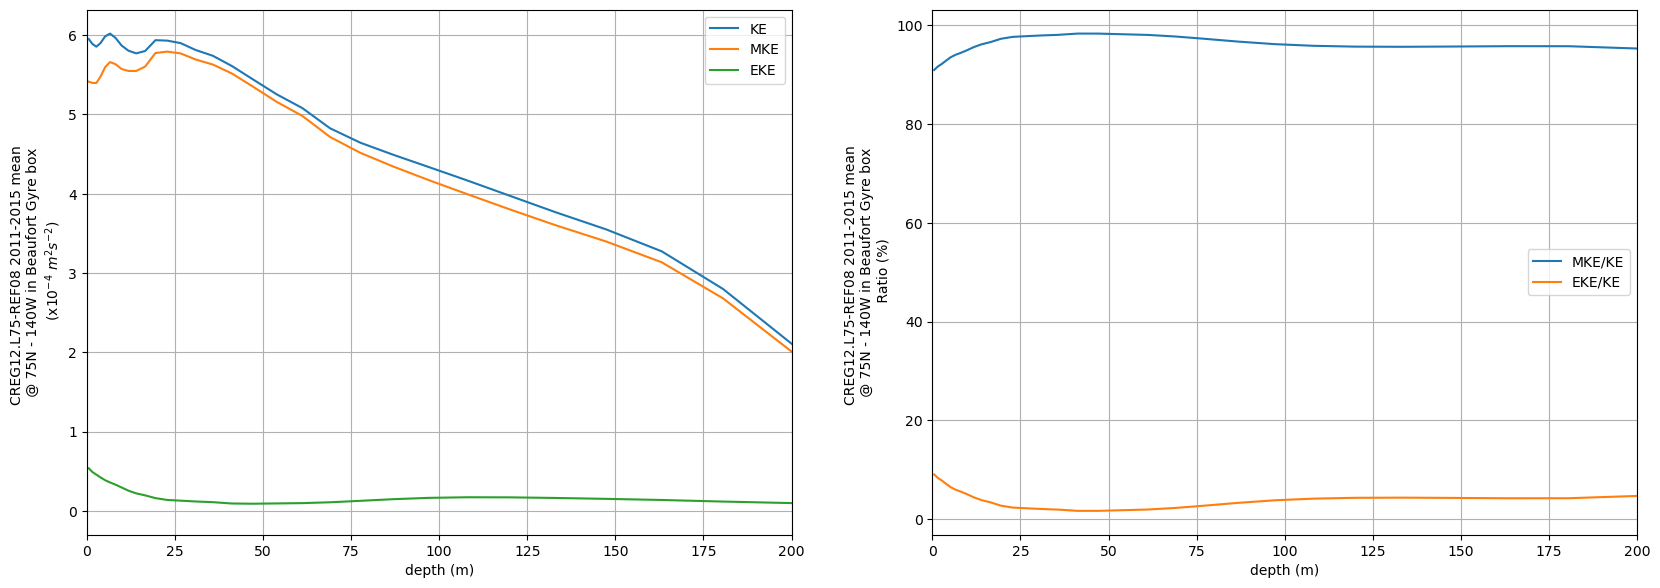

In [82]:
%%time
plt.figure(figsize=(20,15))
plt.subplot(221)
(ds_meanyear.votke*1e4).isel(x=520,y=1500).plot(label='KE')
(ds_meanyear.vomke*1e4).isel(x=520,y=1500).plot.line(label='MKE')
(ds_meanyear.voeke*1e4).isel(x=520,y=1500).plot.line(label='EKE')
plt.title('')
plt.ylabel('CREG12.L75-REF08 2011-2015 mean \n @ 75N - 140W in Beaufort Gyre box \n (x${10}^{-4}$ $m^2s^{-2}$)')
plt.xlabel('depth (m)')
plt.xlim([0,200])
plt.grid(True)
plt.legend()

plt.subplot(222)
((ds_meanyear.vomke/ds_meanyear.votke)*100.).isel(x=520,y=1500).plot.line(label='MKE/KE')
((ds_meanyear.voeke/ds_meanyear.votke)*100.).isel(x=520,y=1500).plot.line(label='EKE/KE')
plt.title('')
plt.ylabel('CREG12.L75-REF08 2011-2015 mean \n @ 75N - 140W in Beaufort Gyre box \n Ratio (%)')
plt.xlabel('depth (m)')
plt.xlim([0,200])
plt.grid(True)
plt.legend()


# A Beaufort Gyre box

In [95]:
%%time
ds_BG_area=((ds_meanyear.coords['nav_lat']<=79.) & (ds_meanyear.coords['nav_lat']>=75.) & \
            (ds_meanyear.coords['nav_lon']>=-158.) & (ds_meanyear.coords['nav_lon']<=-139.)).compute()

CPU times: user 56 ms, sys: 16 ms, total: 72 ms
Wall time: 108 ms


In [96]:
ds_meanyear_BG=ds_meanyear.where(ds_BG_area ,drop=True)

In [97]:
ds_meanyear_BG['area']=ds_mesh.area.where(ds_BG_area ,drop=True).isel(t=0)

In [98]:
ds_meanyear_BG

<xarray.Dataset>
Dimensions:   (deptht: 75, y: 148, x: 165)
Coordinates:
    nav_lat   (y, x) float32 76.54 76.57 76.6 76.63 ... 75.85 75.87 75.88 75.89
    nav_lon   (y, x) float32 -131.0 -131.1 -131.2 ... -164.9 -165.0 -165.2
  * deptht    (deptht) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
Dimensions without coordinates: y, x
Data variables:
    voeke     (deptht, y, x) float32 dask.array<chunksize=(15, 77, 165), meta=np.ndarray>
    votke     (deptht, y, x) float32 dask.array<chunksize=(15, 77, 165), meta=np.ndarray>
    vomke     (deptht, y, x) float32 dask.array<chunksize=(15, 77, 165), meta=np.ndarray>
    logvotke  (deptht, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    logvomke  (deptht, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    logvoeke  (deptht, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    area      (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan

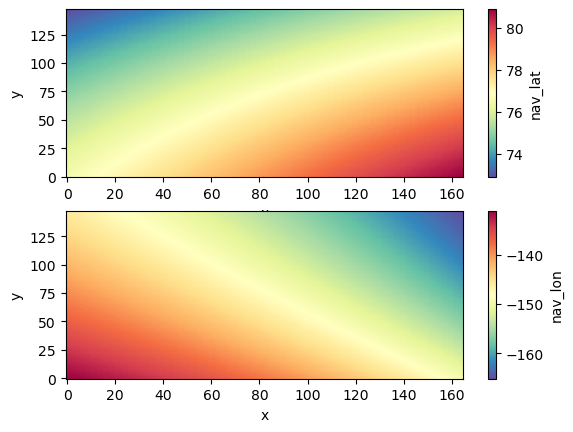

In [99]:
plt.subplot(211)
ds_meanyear_BG.nav_lat.plot(cmap='Spectral_r') 
plt.subplot(212)
ds_meanyear_BG.nav_lon.plot(cmap='Spectral_r') 

In [100]:
%%time
ds_meanyear_BG['votkeZ']=((ds_meanyear_BG.votke*ds_meanyear_BG.area).sum(dim=('y','x'))/ds_meanyear_BG.area.sum(dim=('y','x'))).compute()
ds_meanyear_BG['vomkeZ']=((ds_meanyear_BG.vomke*ds_meanyear_BG.area).sum(dim=('y','x'))/ds_meanyear_BG.area.sum(dim=('y','x'))).compute()
ds_meanyear_BG['voekeZ']=((ds_meanyear_BG.voeke*ds_meanyear_BG.area).sum(dim=('y','x'))/ds_meanyear_BG.area.sum(dim=('y','x'))).compute()

CPU times: user 348 ms, sys: 260 ms, total: 608 ms
Wall time: 3.68 s


In [101]:
%%time
ds_meanyear_BG['RmkeOtkeZ']=(ds_meanyear_BG.vomkeZ/ds_meanyear_BG.votkeZ).compute()
ds_meanyear_BG['RekeOtkeZ']=(ds_meanyear_BG.voekeZ/ds_meanyear_BG.votkeZ).compute()

CPU times: user 0 ns, sys: 4 ms, total: 4 ms
Wall time: 2.45 ms


In [102]:
ds_meanyear_BG

<xarray.Dataset>
Dimensions:    (deptht: 75, y: 148, x: 165)
Coordinates:
    nav_lat    (y, x) float32 76.54 76.57 76.6 76.63 ... 75.85 75.87 75.88 75.89
    nav_lon    (y, x) float32 -131.0 -131.1 -131.2 ... -164.9 -165.0 -165.2
  * deptht     (deptht) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
Dimensions without coordinates: y, x
Data variables:
    voeke      (deptht, y, x) float32 dask.array<chunksize=(15, 77, 165), meta=np.ndarray>
    votke      (deptht, y, x) float32 dask.array<chunksize=(15, 77, 165), meta=np.ndarray>
    vomke      (deptht, y, x) float32 dask.array<chunksize=(15, 77, 165), meta=np.ndarray>
    logvotke   (deptht, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    logvomke   (deptht, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    logvoeke   (deptht, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    area       (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    votkeZ     (deptht) float64 0.0003467 0.0003375 0.0003284 ... 0.0 0.0 0.0
    vomkeZ     (deptht) float64 0.0002727 0.0002722 0.0002721 ... 0.0 0.0 0.0
    voekeZ     (deptht) float64 7.393e-05 6.528e-05 5.632e-05 ... 0.0 0.0 0.0
    RmkeOtkeZ  (deptht) float64 0.7867 0.8066 0.8285 0.8475 ... nan nan nan nan
    RekeOtkeZ  (deptht) float64 0.2133 0.1934 0.1715 0.1525 ... nan nan nan nan

# Compute the mean over each level and plot the vertical  profile 

CPU times: user 36 ms, sys: 0 ns, total: 36 ms
Wall time: 36.5 ms


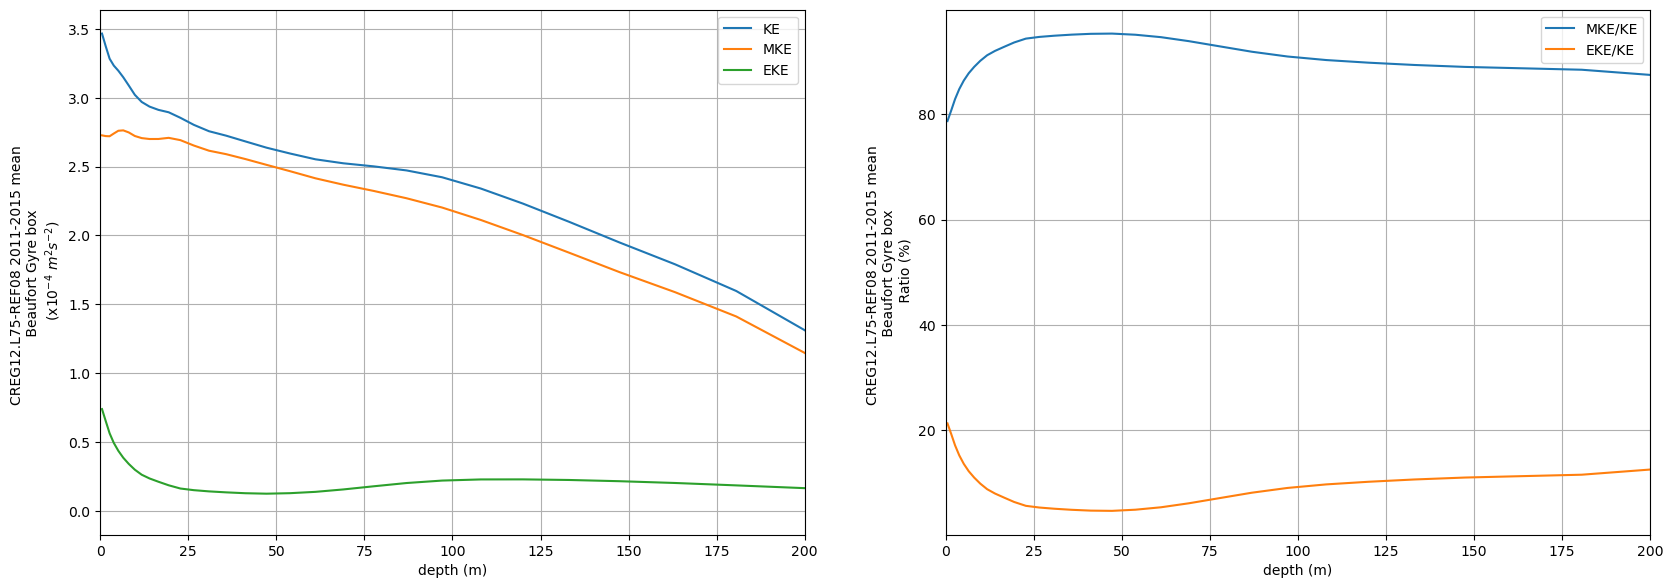

In [105]:
%%time
plt.figure(figsize=(20,15))
plt.subplot(221)
(ds_meanyear_BG.votkeZ*1e4).plot(label='KE')
(ds_meanyear_BG.vomkeZ*1e4).plot.line(label='MKE')
(ds_meanyear_BG.voekeZ*1e4).plot.line(label='EKE')
plt.title('')
plt.ylabel('CREG12.L75-REF08 2011-2015 mean \n Beaufort Gyre box \n (x${10}^{-4}$ $m^2s^{-2}$)')
plt.xlabel('depth (m)')
plt.xlim([0,200])
plt.grid(True)
plt.legend()

plt.subplot(222)
(ds_meanyear_BG.RmkeOtkeZ*100.).plot.line(label='MKE/KE')
(ds_meanyear_BG.RekeOtkeZ*100.).plot.line(label='EKE/KE')
plt.title('')
plt.ylabel('CREG12.L75-REF08 2011-2015 mean \n Beaufort Gyre box \n Ratio (%)')
plt.xlabel('depth (m)')
plt.xlim([0,200])
plt.grid(True)
plt.legend()


CPU times: user 20 ms, sys: 0 ns, total: 20 ms
Wall time: 17.5 ms


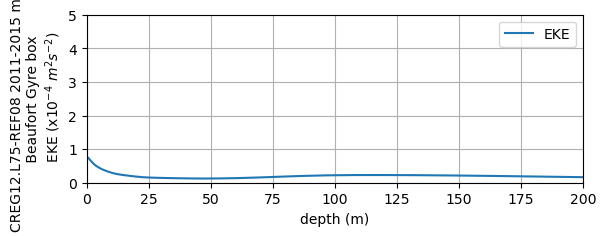

In [104]:
%%time
#plt.figure(figsize=(20,15))
plt.subplot(211)
(ds_meanyear_BG.voekeZ*1e4).plot.line(label='EKE')
plt.title('')
plt.ylabel('CREG12.L75-REF08 2011-2015 mean \n Beaufort Gyre box \n EKE (x${10}^{-4}$ $m^2s^{-2}$)')
plt.xlabel('depth (m)')
plt.xlim([0,200])
plt.ylim([0,5])
plt.grid(True)
plt.legend()

# Find the best box in the Beaufort gyre 

In [48]:
%%time
ds_meanyear['ds_BG_area']=((ds_meanyear.coords['nav_lat']<=77.) & (ds_meanyear.coords['nav_lat']>=74.) & \
                           (ds_meanyear.coords['nav_lon']>=-158.) & (ds_meanyear.coords['nav_lon']<=-139.)).compute()

CPU times: user 1.29 s, sys: 1.34 s, total: 2.64 s
Wall time: 5.66 s


In [106]:
box_BG=xr.where(ds_BG_area,1.,np.nan)

<timed exec>:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


CPU times: user 4.61 s, sys: 88 ms, total: 4.7 s
Wall time: 4.94 s


<Figure size 640x480 with 0 Axes>

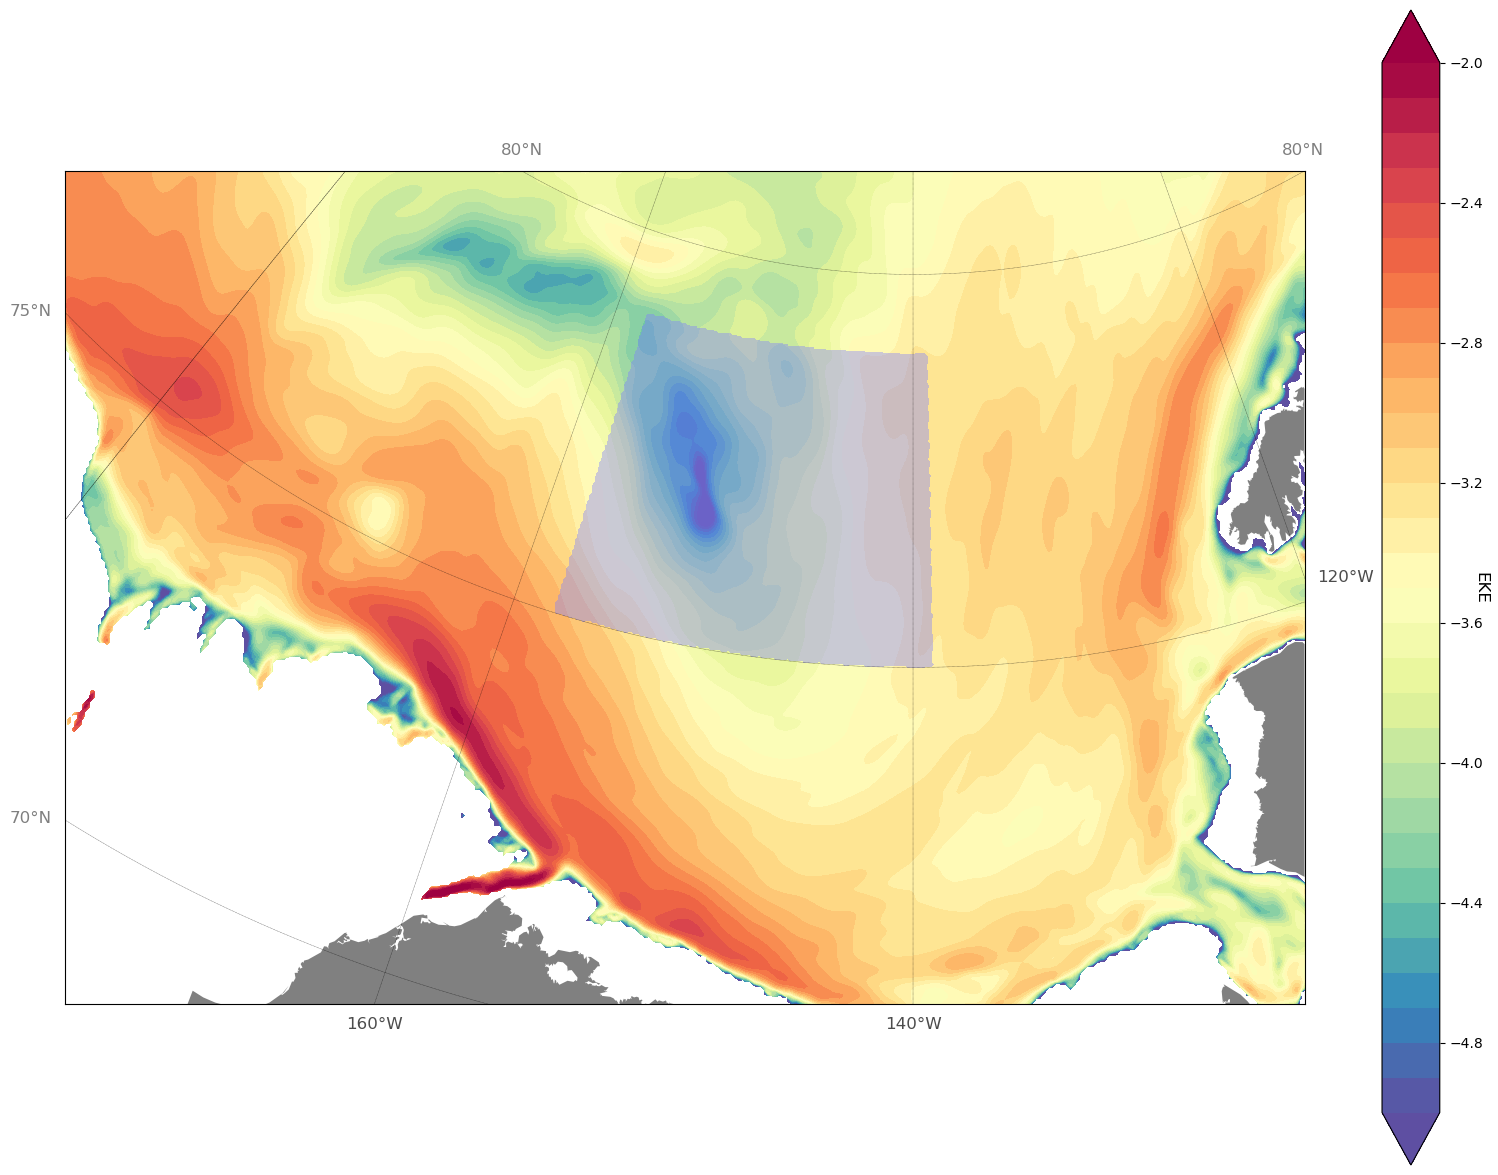

In [107]:
%%time

plt.clf()
vmin=-5. ; vmax=-2. ; vint=0.1
contours=np.arange(vmin,vmax+vint,vint)
limits=[vmin,vmax]   
    
fig=plt.figure(figsize=(20,15))
plt.subplot(111)
C1=Arc_plot(np.array(ds_meanyear['nav_lon']),np.array(ds_meanyear['nav_lat']), \
          (ds_meanyear['logvomke']).sel(deptht=81,method='nearest'), \
         contours, limits, zmap='Spectral_r',proj='cassis_BGZoom',fld='EKE')

norm = mpl.colors.Normalize(vmin=0., vmax=1.)
pal = plt.cm.get_cmap('cool')

X,Y = C1(np.array(ds_meanyear['nav_lon']),np.array(ds_meanyear['nav_lat']))
C2= C1.contourf(X,Y,box_BG,[0.,1.],cmap=pal,norm=norm,alpha=0.4)

#GeoBox(fig,area='zoom')

# Just for fun

In [116]:
plot1=(ds_meanyear_BG['votkeZ']*1e4).hvplot.line(label='KE')
plot2=(ds_meanyear_BG['vomkeZ']*1e4).hvplot.line(label='MKE')
plot3=(ds_meanyear_BG['voekeZ']*1e4).hvplot.line(label='EKE')

#plt.figure(figsize=(20,15))
#plt.subplot(221)
plot_val=(plot1*plot2*plot3)
#plt.grid(True)
#plt.legend()

plot5=(ds_meanyear_BG.RmkeOtkeZ*100.).hvplot.line(label='MKE/KE')
plot6=(ds_meanyear_BG.RekeOtkeZ*100.).hvplot.line(label='EKE/KE')

plot_rat=(plot5*plot6)


(plot_val+plot_rat).cols(1)

:Layout
   .Overlay.I  :Overlay
      .Curve.KE  :Curve   [nav_lev]   (votkeZ)
      .Curve.MKE :Curve   [nav_lev]   (vomkeZ)
      .Curve.EKE :Curve   [nav_lev]   (voekeZ)
   .Overlay.II :Overlay
      .Curve.MKE_over_KE :Curve   [nav_lev]   (RmkeOtkeZ)
      .Curve.EKE_over_KE :Curve   [nav_lev]   (RekeOtkeZ)

In [67]:
client.close()
cluster.close()

/home1/datawork/ctalandi/conda-env/Jupyter-Dask/lib/python3.11/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
